# Camille Girard Think Bayes Homework 5

This notebook presents example code and exercise solutions for Think Bayes.

Camille Girard

MIT License: https://opensource.org/licenses/MIT

In [5]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import classes from thinkbayes2
from thinkbayes2 import Pmf, Suite, Beta, MakeGammaPmf, MakeJoint, Joint
import thinkbayes2

import matplotlib.pyplot as plt
import thinkplot
import pandas as pd
import numpy as np
from scipy.stats import norm, hypergeom
import math
from thinkbayes2 import MakePoissonPmf, Cdf, Pmf, MakeGammaPmf
from scipy.special import expit, logit
from itertools import product
import pymc3 as pm

class BayesTable(pd.DataFrame):
    def __init__(self, hypo, prior=1):
        columns = ['hypo', 'prior', 'likelihood', 'unnorm', 'posterior']
        super().__init__(columns=columns)
        self.hypo = hypo
        self.prior = prior
    
    def mult(self):
        self.unnorm = self.prior * self.likelihood
        
    def norm(self):
        nc = np.sum(self.unnorm)
        self.posterior = self.unnorm / nc
        return nc
    
    def update(self):
        self.mult()
        return self.norm()
    
    def reset(self):
        return BayesTable(self.hypo, self.posterior)

ERROR:root:The 'ast_node_interactivity' trait of a ZMQInteractiveShell instance must be any of ['all', 'last', 'last_expr', 'none'], but a value of 'last_expr_or_assign' <class 'str'> was specified.
/home/cgirard/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Social Desirability Pt.2

In the first version of the social desirability problem, survey respondents followed this protocol:

 Each respondent flips a coin.  If they get heads, they report YES.
    If they get tails, they honestly answer the question.


Suppose someone suggests a slightly different protocol:

Each respondent flips two coins.  If they get heads, they honestly answer the question.  Otherwise they report the result of the second coin, yes for heads and no for tails.


Suppose we use this protocol with 100 people and 60% respond "yes".

1) What is the posterior distribution of the actual proportion of "yes" responses in the population?

2) Is this protocol more or less efficient than the previous one?

In [6]:
class Social(Suite):
    
    def Likelihood(self, data, hypo):
        """
        data: outcome of unreliable measurement, either 'YES' or 'NO'
        hypo: actual proportion of the thing we're measuring
        """
        p = hypo
        p_yes = 0.25 + p/2
        if data == 'YES':
            return p_yes
        else:
            return 1 - p_yes

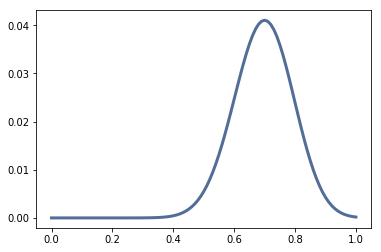

In [7]:
xs = np.linspace(0, 1, 101)
social = Social(xs)
for i in range(60):
    social.Update('YES')
for i in range(40):
    social.Update('NO')
thinkplot.Pdf(social, label='Posterior')

# Climate Change

Climate Change

In [8]:
!wget https://www.ncdc.noaa.gov/cag/global/time-series/0.0,0.0/land_ocean/ytd/12/1880-2018.csv

--2018-11-10 11:02:53--  https://www.ncdc.noaa.gov/cag/global/time-series/0.0,0.0/land_ocean/ytd/12/1880-2018.csv
Resolving www.ncdc.noaa.gov (www.ncdc.noaa.gov)... 205.167.25.171, 205.167.25.172, 2610:20:8040:2::172, ...
Connecting to www.ncdc.noaa.gov (www.ncdc.noaa.gov)|205.167.25.171|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1320 (1.3K) [text/plain]
Saving to: ‘1880-2018.csv.1’

1880-2018.csv.1     100%[===================>]   1.29K  --.-KB/s    in 0s      

2018-11-10 11:02:56 (36.2 MB/s) - ‘1880-2018.csv.1’ saved [1320/1320]



In [10]:
columns = ['Year', 'Value']
df = pd.read_csv('1880-2018.csv', parse_dates=[0])
df.drop(labels=[3, 24], inplace=True)
df

,0.0 deg N,0.0 deg E Temperature Anomalies,January-December
0,Units: Degrees Celsius,NaN,NaN
1,Base Period: 1981-2010,NaN,NaN
2,Missing: -9999,NaN,NaN
4,1896,-1.05,NaN
5,1902,-1.50,NaN
6,1903,-1.94,NaN
7,1904,-2.10,NaN
8,1905,-1.74,NaN
9,1906,-1.68,NaN
10,1907,-1.15,NaN


# Space Shuttle Problem

On January 28, 1986, the twenty-fifth flight of the U.S. space shuttle program ended in disaster when one of the rocket boosters of the Shuttle Challenger exploded shortly after lift-off, killing all seven crew members. The presidential commission on the accident concluded that it was caused by the failure of an O-ring in a field joint on the rocket booster, and that this failure was due to a faulty design that made the O-ring unacceptably sensitive to a number of factors including outside temperature. Of the previous 24 flights, data were available on failures of O-rings on 23, (one was lost at sea), and these data were discussed on the evening preceding the Challenger launch, but unfortunately only the data corresponding to the 7 flights on which there was a damage incident were considered important and these were thought to show no obvious trend. The data are shown below (see [1]):

# The Bug Problem

Suppose that you are an ecologist sampling the insect population in a new environment. You deploy 100 traps in a test area and come back the next day to check on them. You find that 37 traps have been triggered, trapping an insect inside. Once a trap triggers, it cannot trap another insect until it has been reset.

If you reset the traps and come back in two days, how many traps do you expect to find triggered? Compute a posterior predictive distribution for the number of traps.

# The Light Bulb Problem

Suppose you are the manager of an apartment building with 100 light bulbs in common areas. It is your responsibility to replace light bulbs when they break.

On January 1, all 100 bulbs are working. When you inspect them on February 1, you find 3 light bulbs out. If you come back on April 1, how many light bulbs do you expect to find broken?

For light bulbs, the likelihood of failure depends on the age of the bulb. Specifically, old bulbs have an increasing failure rate due to evaporation of the filament (see The Light Bulb Conspiracy).

This problem is more open-ended than some; you will have to make modeling decisions. You might want to read about the Weibull distribution (http://en.wikipedia.org/wiki/Weibull_distribution). Or you might want to look around for information about light bulb survival curves.

# Battleship Problem

For the "Battleship" scenario on the quiz, suppose you take a few shots and miss.  After you update your beliefs about the location of the ship, where should you guess next?

Suppose you choose at random among positions with equal probability of having a ship.  After a few shots, what does the posterior probability on the grid look like?

# Flee Beetle Revisited

The initial solution to this problem

1) Ignores the correlation between width and angle, and

2) Estimates the mean and standard deviation of each attribute, for each species, and then treats the estimates as if they were known with certainty.

Fix one or both of these problems and see how much difference it makes.